In [1]:
#Import thư viện
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Đọc dữ liệu csv
data = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
data.shape

(2113, 18)

In [3]:
data.head()

,first_name,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Roselin,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Loren,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Odele,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Teressa,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Isidor,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


# Tiền xử lý dữ liệu

## Trích chọn dữ liệu: 
Dựa vào phân tích tập dữ liệu, em nhận thấy rằng trường 'first_name' không cần thiết cho mục đích dự đoán mức độ béo phì. Do đó, thực hiện việc xóa cột này khỏi tập dữ liệu để tối ưu hóa quá trình xử lý và giảm độ phức tạp của dữ liệu.

In [4]:
data.drop(columns=['first_name'], inplace=True)
print("(Mẫu, thuộc tính) sau khi trích chọn:", data.shape)

(Mẫu, thuộc tính) sau khi trích chọn: (2113, 17)


### Mối tương quan giữa các thuộc tính

#### Gender, Height, Weight
Có thể thấy rằng mặc dù nam (Male) thường có chiều cao trung bình cao hơn so với nữ (Female), nhưng cả nam và nữ đều có phân bổ cân nặng trung bình tương đương. Tuy nhiên, nữ có phạm vi cân nặng lớn hơn đáng kể so với nam. Điều này được minh họa rõ hơn ở biểu đồ trực quan bên dưới.
Một giải thích có thể là do sự khác biệt trong phân bố mỡ cơ thể giữa nam và nữ. Nữ thường có tỉ lệ mỡ cơ thể cao hơn so với nam, dẫn đến sự đa dạng lớn hơn trong phân bố cân nặng. Trong khi đó, nam thường có phân bố mỡ cơ thể thấp hơn, dẫn đến phân bố cân nặng ít biến thiên hơn.

<Axes: xlabel='Gender', ylabel='Weight'>

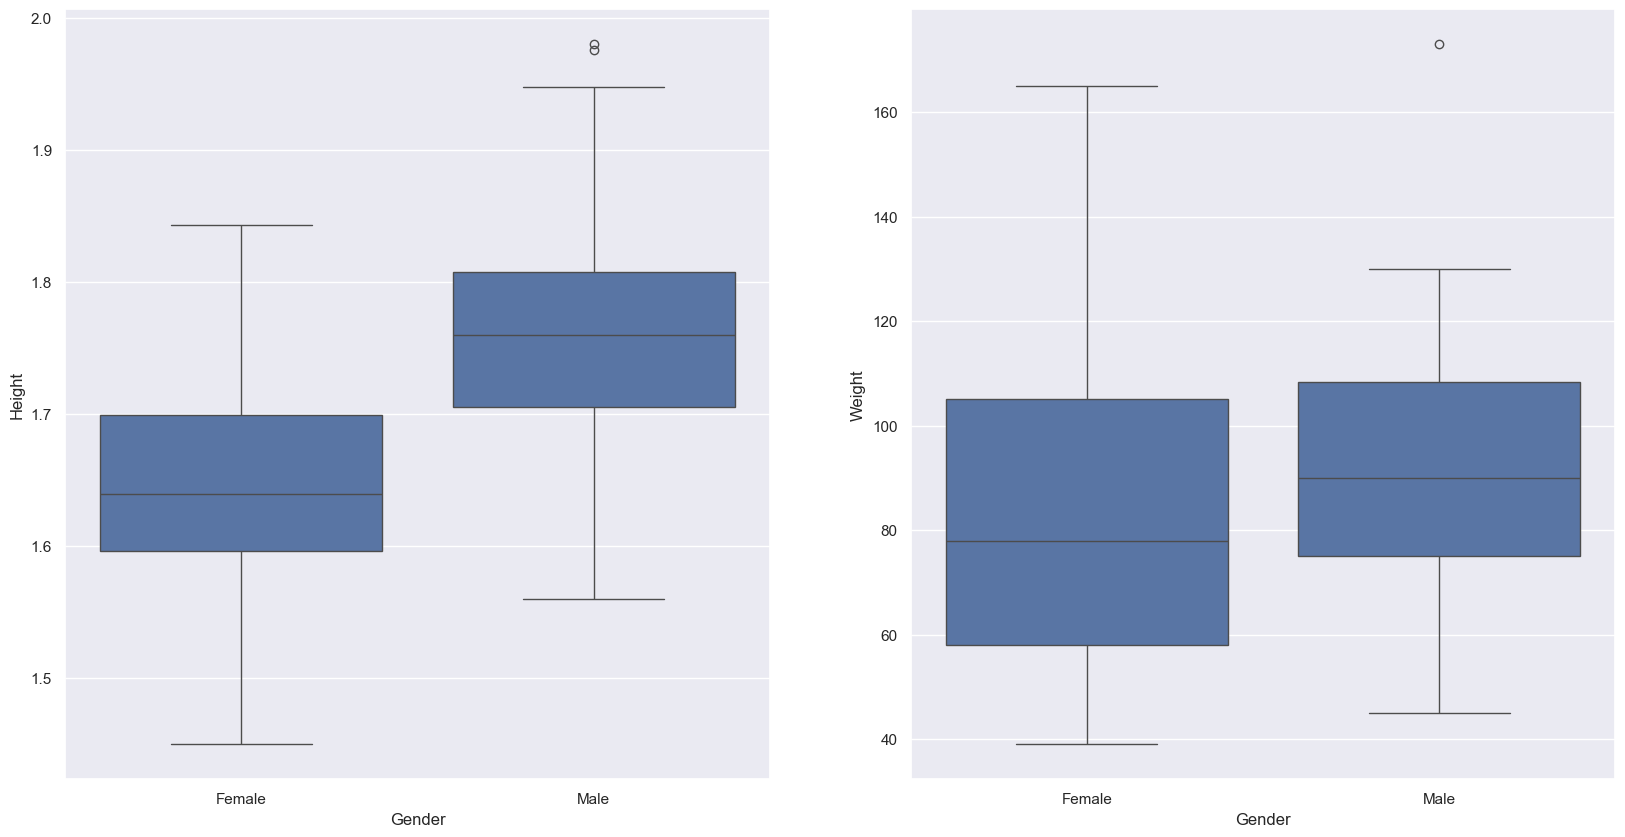

In [5]:
sns.set_theme()
fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.boxplot(x='Gender', y='Height', data=data)
plt.subplot(1, 2, 2)
sns.boxplot(x='Gender', y='Weight', data=data)

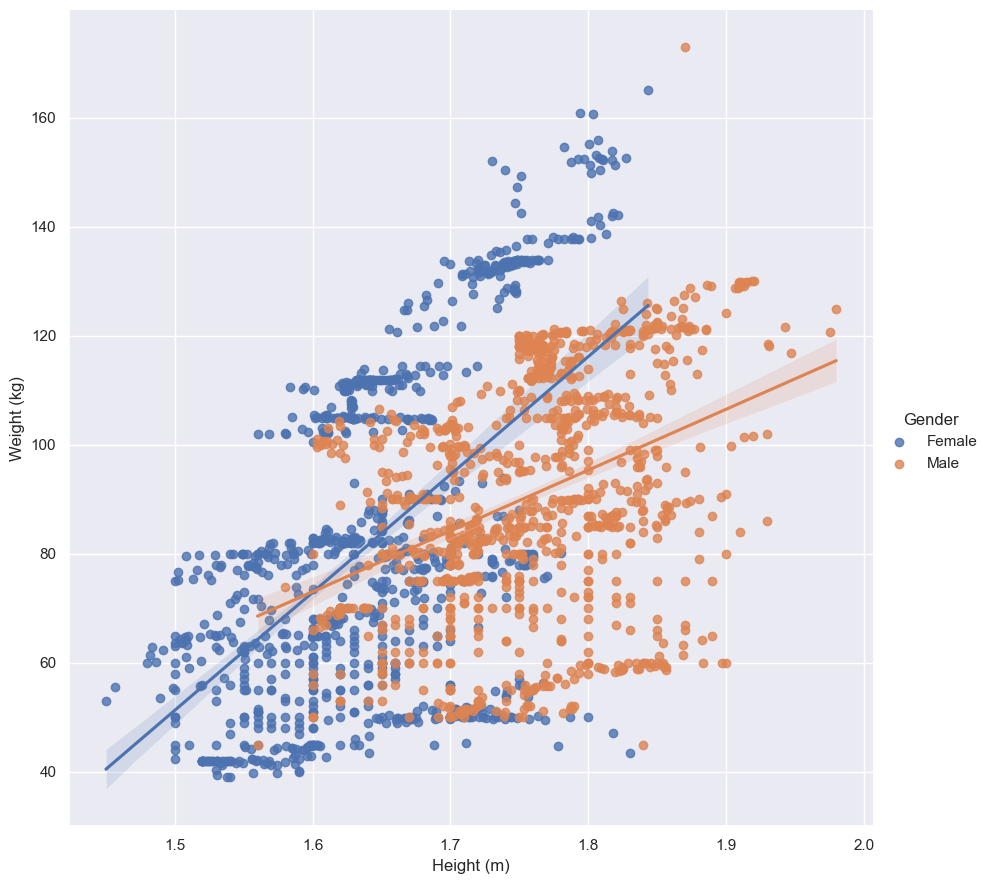

In [6]:
g = sns.lmplot(x="Height", y="Weight", hue="Gender",
               height=9, data=data)
g.set_axis_labels("Height (m)", "Weight (kg)")

#### Mối tương quan family_history_with_overweigh, weight
Có thể thấy rằng những người có cân nặng cao thường dễ có tiền sử gia đình bị bệnh béo phì. Mặc dù cân nặng cao không nhất thiết đồng nghĩa với bệnh béo phì, nhưng nó thường là một yếu tố nguy cơ. Một giải thích có thể là do di truyền, trong đó các yếu tố gen từ gia đình có thể góp phần vào việc xác định khả năng tích tụ mỡ trong cơ thể.
Sự ảnh hưởng của tiền sử gia đình đối với cân nặng và bệnh béo phì có thể được minh họa thông qua biểu đồ trực quan bên dưới. Những người có tiền sử gia đình về bệnh béo phì thường có xu hướng có cân nặng cao hơn so với những người không có tiền sử này. Điều này có thể phản ánh sự kế thừa của yếu tố gen liên quan đến quá trình trao đổi chất và lưu trữ mỡ trong cơ thể.
Tuy nhiên, cũng cần lưu ý rằng cân nặng không chỉ phụ thuộc vào yếu tố gen mà còn ảnh hưởng bởi lối sống và môi trường. Do đó, mặc dù tiền sử gia đình có thể là một yếu tố quan trọng, nhưng việc duy trì một lối sống lành mạnh với chế độ dinh dưỡng cân đối và việc tập thể dục đều có thể giúp giảm nguy cơ béo phì và cân nặng cao.

<Axes: xlabel='family_history_with_overweight', ylabel='Weight'>

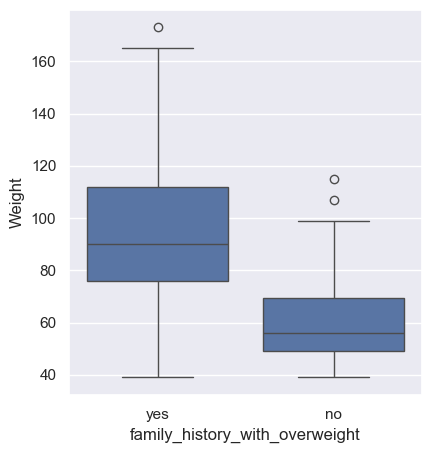

In [7]:
sns.set_theme()
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
sns.boxplot(x='family_history_with_overweight', y='Weight', data=data)

#### Mối tương quan family_history_with_overweigh và NObeyesdad

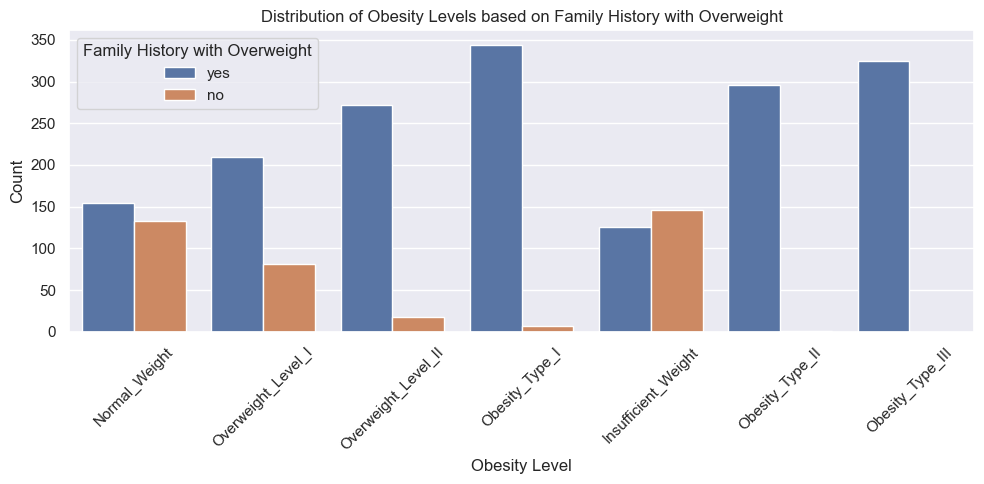

In [8]:
# Vẽ biểu đồ phân phối của nhãn NObeyesdad dựa trên family_history_with_overweight
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='NObeyesdad', hue='family_history_with_overweight')
plt.xlabel('Obesity Level')
plt.ylabel('Count')
plt.title('Distribution of Obesity Levels based on Family History with Overweight')
plt.xticks(rotation=45)  # Xoay nhãn trục x để dễ đọc
plt.legend(title='Family History with Overweight')
plt.tight_layout()
plt.show()

Biểu đồ trên đã làm sáng tỏ mối liên hệ chặt chẽ giữa tiền sử gia đình và mức độ béo phì. Các kết quả cho thấy rằng tiền sử gia đình thừa cân có ảnh hưởng đáng kể đến mức độ béo phì của cá nhân, với những người có tiền sử gia đình thừa cân thường có xu hướng phát triển mức độ béo phì cao hơn. Điều này làm nổi bật vai trò quan trọng của yếu tố di truyền trong việc định hình cơ địa và sức khỏe của mỗi người. Tuy nhiên, cũng cần nhấn mạnh rằng không phải tất cả các trường hợp có tiền sử gia đình thừa cân đều dẫn đến béo phì. Các biến số khác như chế độ ăn uống, lối sống và môi trường cũng đóng vai trò quan trọng trong việc ảnh hưởng đến biến thể của mức độ béo phì.

#### Mối tương quan FAVC và NObeyesdad

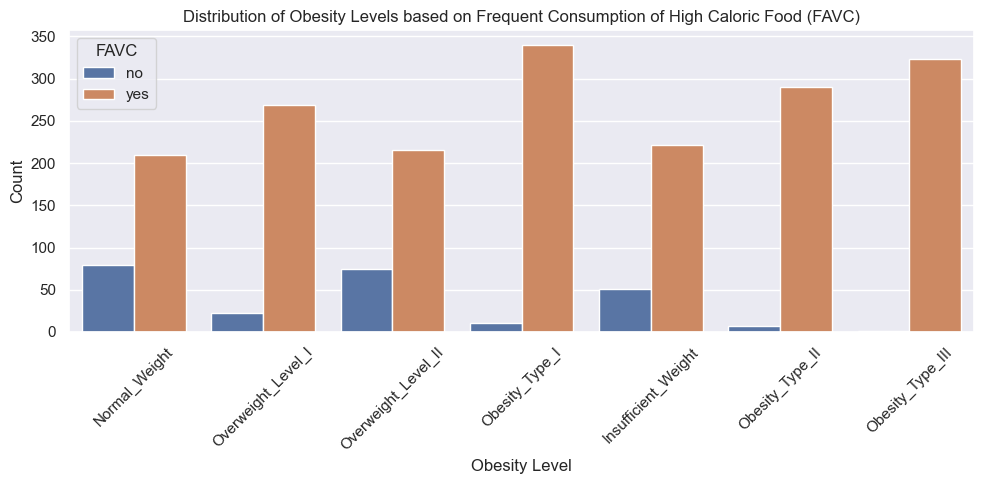

In [9]:
# Vẽ biểu đồ phân phối của nhãn NObeyesdad dựa trên FAVC
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='NObeyesdad', hue='FAVC')
plt.xlabel('Obesity Level')
plt.ylabel('Count')
plt.title('Distribution of Obesity Levels based on Frequent Consumption of High Caloric Food (FAVC)')
plt.xticks(rotation=45)  # Xoay nhãn trục x để dễ đọc
plt.legend(title='FAVC')
plt.tight_layout()
plt.show()

Thông qua biểu đồ này, có thể thấy rõ rằng những người thường xuyên tiêu thụ thực phẩm có hàm lượng calo cao thường có nguy cơ mắc bệnh béo phì cao hơn so với những người tiêu thụ các thực phẩm có hàm lượng calo thấp hơn. Điều này có thể lý giải bởi sự tập trung của chất béo và đường trong thực phẩm có hàm lượng calo cao, hai yếu tố chính gây ra tích tụ mỡ trong cơ thể. Đây là một cảnh báo nghiêm trọng về tình trạng sức khỏe và nhấn mạnh rằng chế độ ăn uống cân đối và lành mạnh là cực kỳ quan trọng. Việc lựa chọn thông minh các loại thực phẩm và duy trì hoạt động thể chất là chìa khóa để giảm thiểu nguy cơ béo phì và bảo vệ sức khỏe toàn diện.

#### Mối tương quan CAEC và NObeyesdad

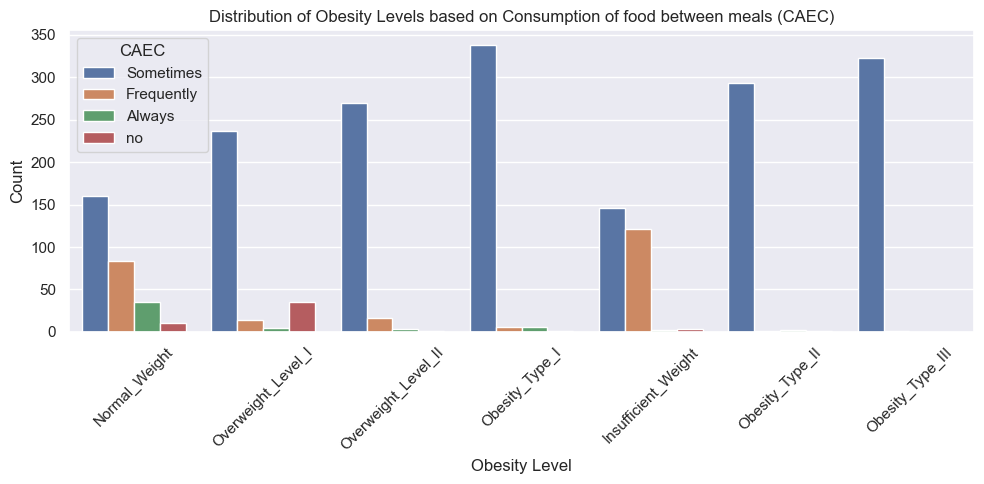

In [10]:
# Vẽ biểu đồ phân phối của nhãn NObeyesdad dựa trên CAEC
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='NObeyesdad', hue='CAEC')
plt.xlabel('Obesity Level')
plt.ylabel('Count')
plt.title('Distribution of Obesity Levels based on Consumption of food between meals (CAEC)')
plt.xticks(rotation=45)  
plt.legend(title='CAEC')
plt.tight_layout()
plt.show()

Biểu đồ trên thể hiện sự liên hệ giữa tần suất tiêu thụ thức ăn giữa các bữa ăn (CAEC) và tình trạng béo phì. Kết quả cho thấy, dù mức độ tiêu thụ thức ăn giữa các bữa ăn là "Sometimes", nhưng không thể kết luận rằng nó ảnh hưởng đến tình trạng béo phì vì "Sometimes" được phân phối trên tất cả các mức độ tình trạng sức khỏe. Điều này nhấn mạnh rằng CAEC không đóng vai trò chính trong việc xác định nguyên nhân của béo phì và có thể cần xem xét thêm các yếu tố khác như lối sống, di truyền và chế độ ăn uống tổng thể.

#### Mối tương quan SMOKE và NObeyesdad

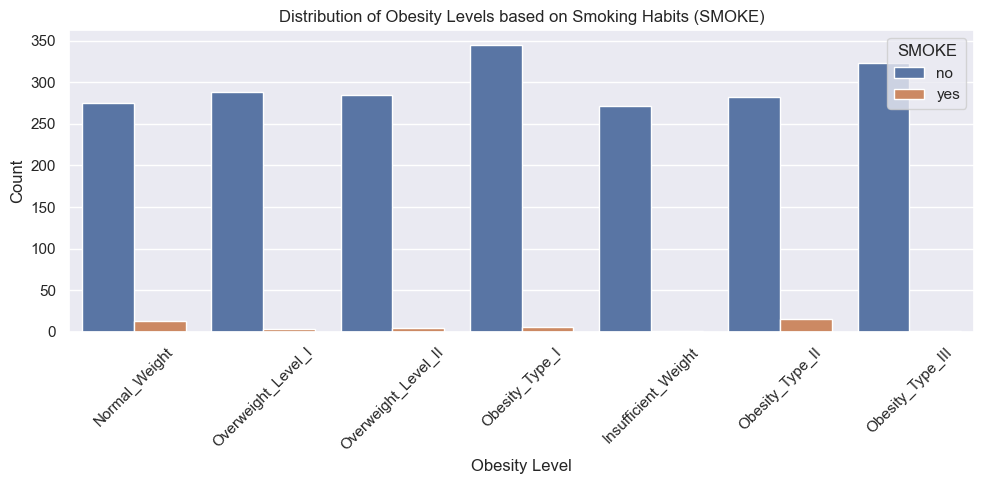

In [11]:
# Vẽ biểu đồ phân phối của nhãn NObeyesdad dựa trên SMOKE
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='NObeyesdad', hue='SMOKE')
plt.xlabel('Obesity Level')
plt.ylabel('Count')
plt.title('Distribution of Obesity Levels based on Smoking Habits (SMOKE)')
plt.xticks(rotation=45)  
plt.legend(title='SMOKE')
plt.tight_layout()
plt.show()

Biểu đồ phân phối mức độ béo phì dựa trên thói quen hút thuốc là một công cụ hữu ích để đánh giá mối liên hệ giữa hai yếu tố này trong dân số. Khi phân tích biểu đồ trên, em thấy rằng số lượng người không hút thuốc lá chiếm phần lớn trong dữ liệu và có xu hướng phân phối khá đồng đều trên các mức độ béo phì. Tuy nhiên, điều đáng chú ý là mặc dù số lượng người không hút thuốc lá nhiều hơn đáng kể so với số người hút thuốc lá, nhưng tỷ lệ nguy cơ mắc bệnh béo phì giữa hai nhóm này không có sự chênh lệch lớn. Điều này cho thấy rằng, trong phạm vi tập dữ liệu này, sự hiện diện của thói quen hút thuốc có thể không ảnh hưởng đáng kể đến mức độ béo phì. 

Mặc dù người hút thuốc lá có thể có các yếu tố nguy cơ khác gây ra béo phì, nhưng dữ liệu này gợi ý rằng thói quen hút thuốc lá không phải là một yếu tố quyết định trong việc xác định mức độ béo phì trong dân số nghiên cứu. Điều này làm nảy sinh những câu hỏi về các yếu tố khác có thể ảnh hưởng đến béo phì và cần được tiếp tục nghiên cứu để có cái nhìn toàn diện hơn về vấn đề này.

#### Mối tương quan SCC và NObeyesdad

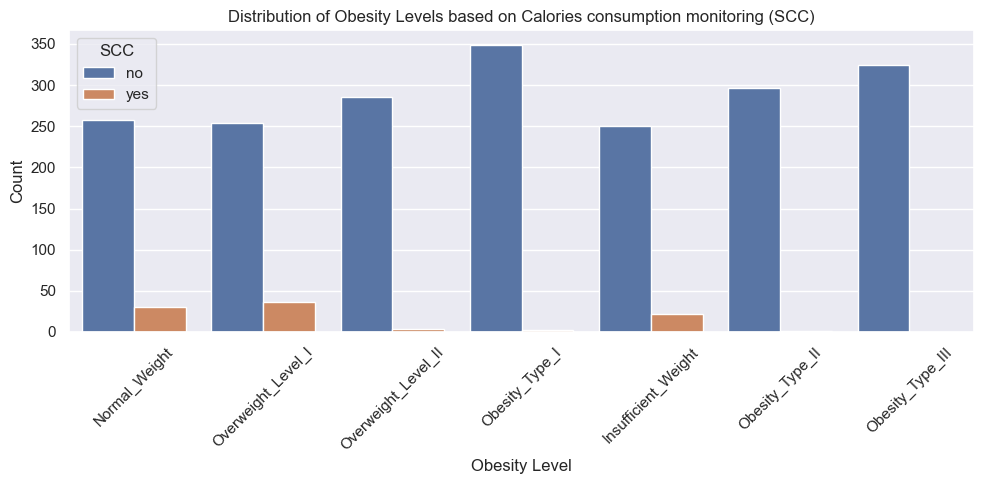

In [12]:
# Vẽ biểu đồ phân phối của nhãn NObeyesdad dựa trên SCC
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='NObeyesdad', hue='SCC')
plt.xlabel('Obesity Level')
plt.ylabel('Count')
plt.title('Distribution of Obesity Levels based on Calories consumption monitoring (SCC)')
plt.xticks(rotation=45)  # Xoay nhãn trục x để dễ đọc
plt.legend(title='SCC')
plt.tight_layout()
plt.show()

Việc theo dõi lượng calo có vai trò quan trọng trong việc duy trì cân nặng và phòng tránh béo phì. Tuy nhiên, biểu đồ trên đã chỉ ra rằng việc này không phải lúc nào cũng là chìa khóa duy nhất. Có những người không theo dõi calo nhưng vẫn duy trì cân nặng lý tưởng hay thậm chí bị thiếu cân, trong khi đó, có những người tuân thủ chặt chẽ calo nhưng vẫn gặp vấn đề về cân nặng. Điều này nhấn mạnh rằng ngoài calo, còn nhiều yếu tố khác cần xem xét như di truyền, hoạt động thể chất và chế độ ăn uống tổng thể. Do đó, việc theo dõi calo chỉ là một phần nhỏ trong việc duy trì sức khỏe và cân nặng lý tưởng.

#### Mối tương quan CALC và NObeyesdad
Trong một xã hội mà béo phì và các vấn đề liên quan đến sức khỏe đang trở thành mối quan tâm ngày càng lớn, hiểu biết về mối quan hệ giữa tiêu thụ rượu và béo phì là rất quan trọng. Điều này, có thể giúp thúc đẩy nhận thức về tác động của việc tiêu thụ rượu và khuyến khích sự tiêu thụ có trách nhiệm, cùng với việc duy trì một lối sống lành mạnh và cân đối.

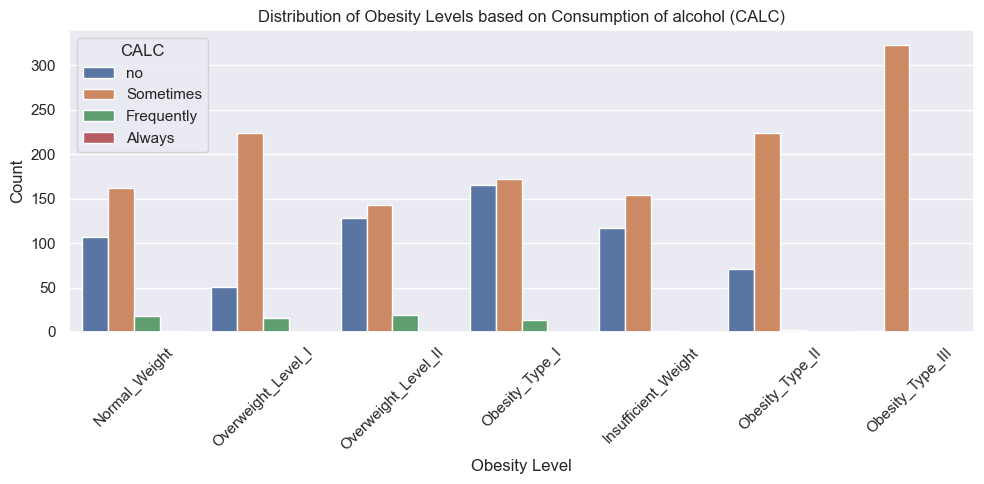

In [13]:
# Vẽ biểu đồ phân phối của nhãn NObeyesdad dựa trên CALC
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='NObeyesdad', hue='CALC')
plt.xlabel('Obesity Level')
plt.ylabel('Count')
plt.title('Distribution of Obesity Levels based on Consumption of alcohol (CALC)')
plt.xticks(rotation=45)
plt.legend(title='CALC')
plt.tight_layout()
plt.show()

Biểu đồ trên đã minh họa mối quan hệ giữa việc tiêu thụ rượu và mức độ béo phì. Từ đó, đưa ra một sự nhìn nhận quan trọng về tác động của việc uống rượu đối với sức khỏe. Mặc dù, có sự phân bố của việc tiêu thụ rượu ở mọi mức độ, nhưng có một xu hướng rõ ràng: những người tiêu thụ rượu thường có nguy cơ cao hơn về béo phì. Điều này có thể được hiểu qua một loạt các yếu tố. Thứ nhất, rượu chứa nhiều calo, và việc tiêu thụ nhiều calo hơn so với lượng calo cần thiết có thể dẫn đến tăng cân. Thứ hai, rượu có thể kích thích việc tiêu thụ thêm thức ăn hoặc đồ ăn chứa nhiều calo, đặc biệt là khi người ta tiêu thụ rượu trong môi trường xã hội hoặc kèm theo bữa ăn.

#### Mối tương quan MTRANS và NObeyesdad

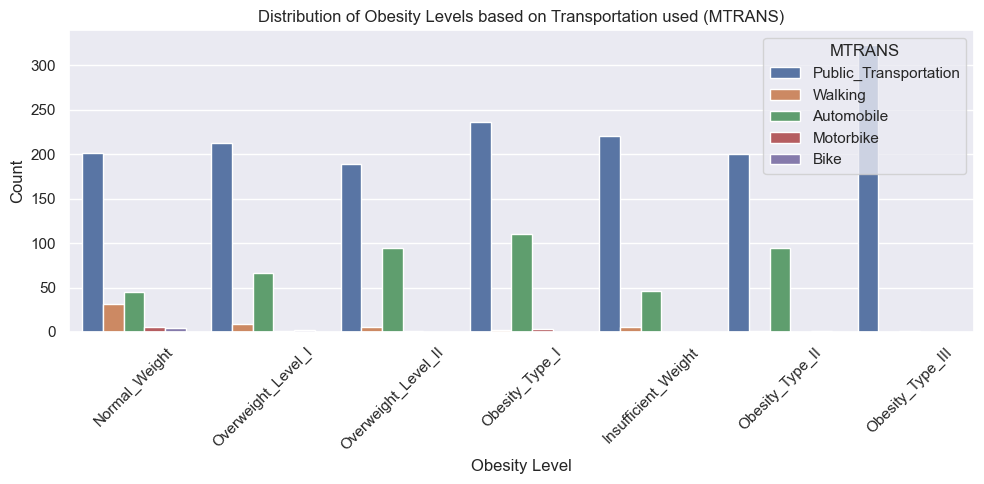

In [14]:
# Vẽ biểu đồ phân phối của nhãn NObeyesdad dựa trên MTRANS
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='NObeyesdad', hue='MTRANS')
plt.xlabel('Obesity Level')
plt.ylabel('Count')
plt.title('Distribution of Obesity Levels based on Transportation used (MTRANS)')
plt.xticks(rotation=45) 
plt.legend(title='MTRANS')
plt.tight_layout()
plt.show()

Quan sát hình trên cho thấy, biểu đồ phân phối của các mức béo phì dựa trên phương tiện di chuyển (MTRANS) cung cấp một cái nhìn tổng quan về mối liên hệ giữa lối sống di chuyển và tình trạng sức khỏe. Thông qua việc phân tích, em nhận thấy rằng không có sự khác biệt đáng kể nào trong phân phối béo phì dựa trên phương tiện di chuyển. Tuy nhiên, cần lưu ý rằng biểu đồ chỉ là một cái nhìn tổng quan và không thể hiện mối liên hệ nhân quả trực tiếp. Để hiểu rõ hơn về mối quan hệ giữa lối sống di chuyển và béo phì, cần thực hiện nghiên cứu chi tiết hơn về thói quen di chuyển và tình trạng sức khỏe của từng cá nhân. Những thông tin này sẽ cung cấp sự hiểu biết sâu hơn và hỗ trợ trong việc phát triển các chiến lược và chính sách nhằm cải thiện sức khỏe cộng đồng.

### Xác định các biến phân loại trong dữ liệu, trực quan hóa các biến phân loại
Cụ thể, kiểm tra kiểu dữ liệu của mỗi cột trong tập dữ liệu. Nếu cột có kiểu dữ liệu là 'object', điều này thường chỉ ra rằng cột đó chứa các giá trị không phải là số, thường là các chuỗi ký tự. Nó được coi là một biến phân loại. Việc xử lý dữ liệu này nhằm chuyển đổi các biến phân loại này thành các biến số học, để có thể sử dụng chúng trong các mô hình học máy.

In [15]:
# xác định biến phân loại
categorical = data.dtypes == object

print(categorical)

# khi dtype == object thì là 'true'
print(categorical[categorical])
categorical_labels = categorical[categorical].index
print('Categorical variables:', categorical_labels)

# Khi dtype == object thì là 'false'
false = categorical[~categorical]
non_categorical = false.index
print('Non Categorical variables:', non_categorical)

Gender                             True
Age                               False
Height                            False
Weight                            False
family_history_with_overweight     True
FAVC                               True
FCVC                              False
NCP                               False
CAEC                               True
SMOKE                              True
CH2O                              False
SCC                                True
FAF                               False
TUE                               False
CALC                               True
MTRANS                             True
NObeyesdad                         True
dtype: bool
Gender                            True
family_history_with_overweight    True
FAVC                              True
CAEC                              True
SMOKE                             True
SCC                               True
CALC                              True
MTRANS                            T

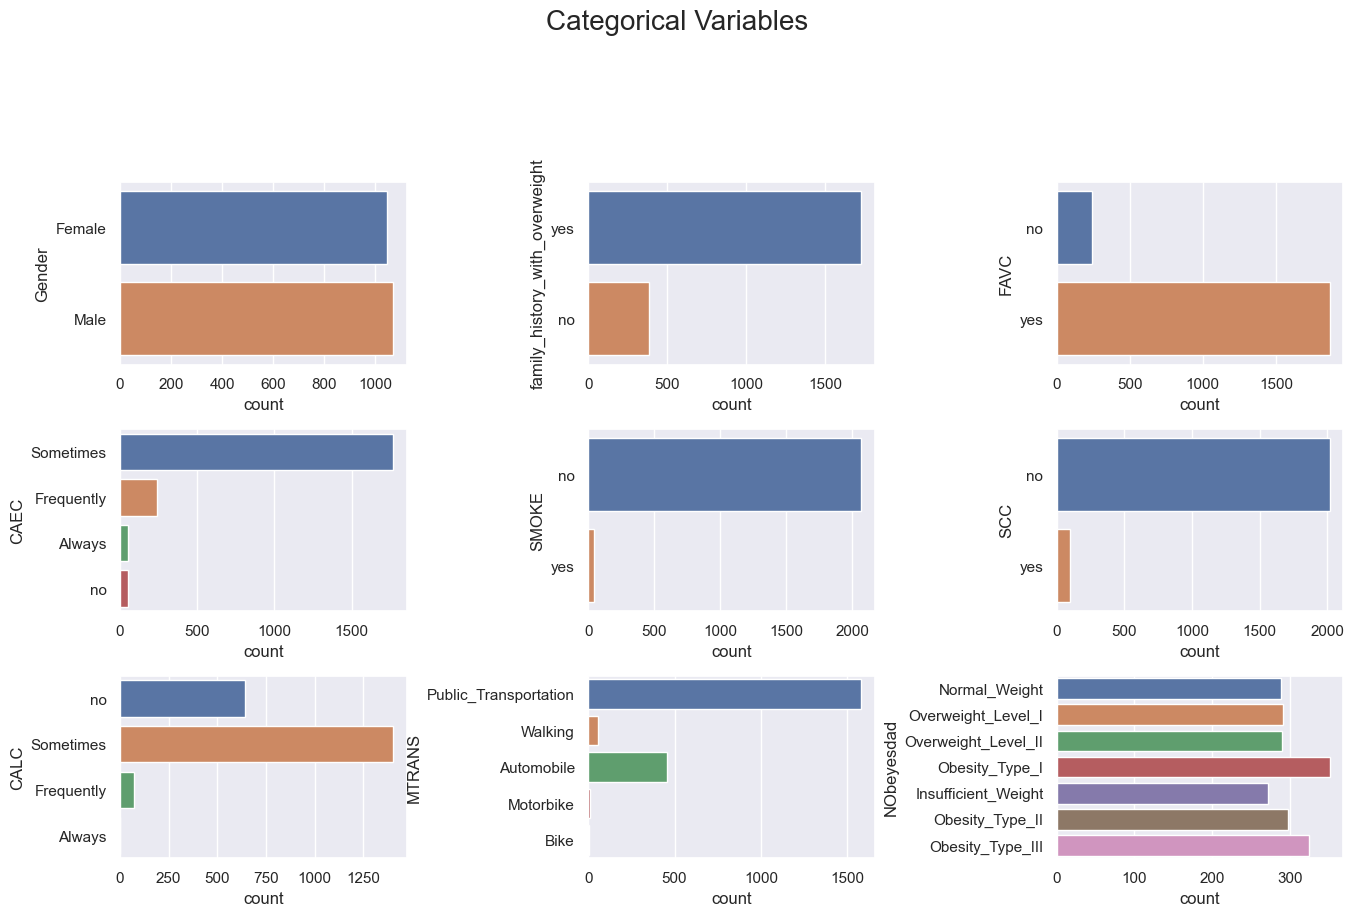

In [16]:
columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
           'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Tạo lưới ô con 3x3
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

# Xác định bảng màu
palette = sns.color_palette("deep")

# Vẽ từng biến phân loại với bảng màu được chỉ định
for col, subplot in zip(columns, ax.flatten()):
    sns.countplot(data[col], ax=subplot, palette=palette)


# Đặt tiêu đề và điều chỉnh bố cục
fig.suptitle("Categorical Variables", fontsize=20)
plt.tight_layout(pad=5, w_pad=0.0, h_pad=1)
plt.show()

In [17]:
# Chuyển đổi các cột có dạng chuỗi thành số
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})
data['family_history_with_overweight'] = data['family_history_with_overweight'].map({'no': 0, 'yes': 1})
data['FAVC'] = data['FAVC'].map({'no': 0, 'yes': 1})
data['CAEC'] = data['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
data['SMOKE'] = data['SMOKE'].map({'no': 0, 'yes': 1})
data['SCC'] = data['SCC'].map({'no': 0, 'yes': 1})
data['CALC'] = data['CALC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
data['MTRANS'] = data['MTRANS'].map({'Walking': 0, 'Public_Transportation': 1, 'Automobile': 2, 'Motorbike': 3, 'Bike': 4})

# Chuyển đổi cột NObeyesdad thành số
data['NObeyesdad'] = data['NObeyesdad'].map({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2,
                                             'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5,
                                             'Obesity_Type_III': 6})

### Biểu đồ nhiệt tương quan
Trong quá trình phân tích dữ liệu, hiểu rõ mối quan hệ giữa các biến số là vô cùng quan trọng để đưa ra kết luận có ý nghĩa và quyết định chính xác. Một công cụ hữu ích để làm điều này là biểu đồ nhiệt tương quan, giúp dễ dàng nhận biết và giải thích mối quan hệ giữa các biến trong tập dữ liệu. Biểu đồ nhiệt tương quan hiển thị mức độ tương quan giữa các biến bằng cách sử dụng màu sắc khác nhau. Mỗi ô vuông trong biểu đồ này thể hiện hệ số tương quan giữa hai biến, với màu sắc biểu thị mức độ tương quan. Ví dụ, màu đỏ thường cho biết tương quan dương mạnh, màu xanh dương thường cho biết tương quan âm mạnh, và các màu sắc trung gian biểu thị mức độ tương quan trung bình hoặc yếu. Biểu đồ này giúp trả lời các câu hỏi như: Các biến nào có mối quan hệ chặt chẽ với nhau? Có biến nào không có tương quan hoặc ít tương quan với các biến khác không? Các nhóm biến nào có thể được sử dụng để xây dựng các mô hình dự báo hoặc phân loại? Phân tích biểu đồ nhiệt tương quan giúp rút ra kết luận quan trọng về mối quan hệ giữa các biến, hỗ trợ trong nghiên cứu y học, dinh dưỡng, và lập kế hoạch can thiệp sức khỏe cộng đồng. Đồng thời, biểu đồ này cũng là công cụ hữu ích để hiểu về tương tác giữa các yếu tố trong nhiều lĩnh vực như y tế, xã hội học, khoa học dữ liệu, và nhiều lĩnh vực khác.

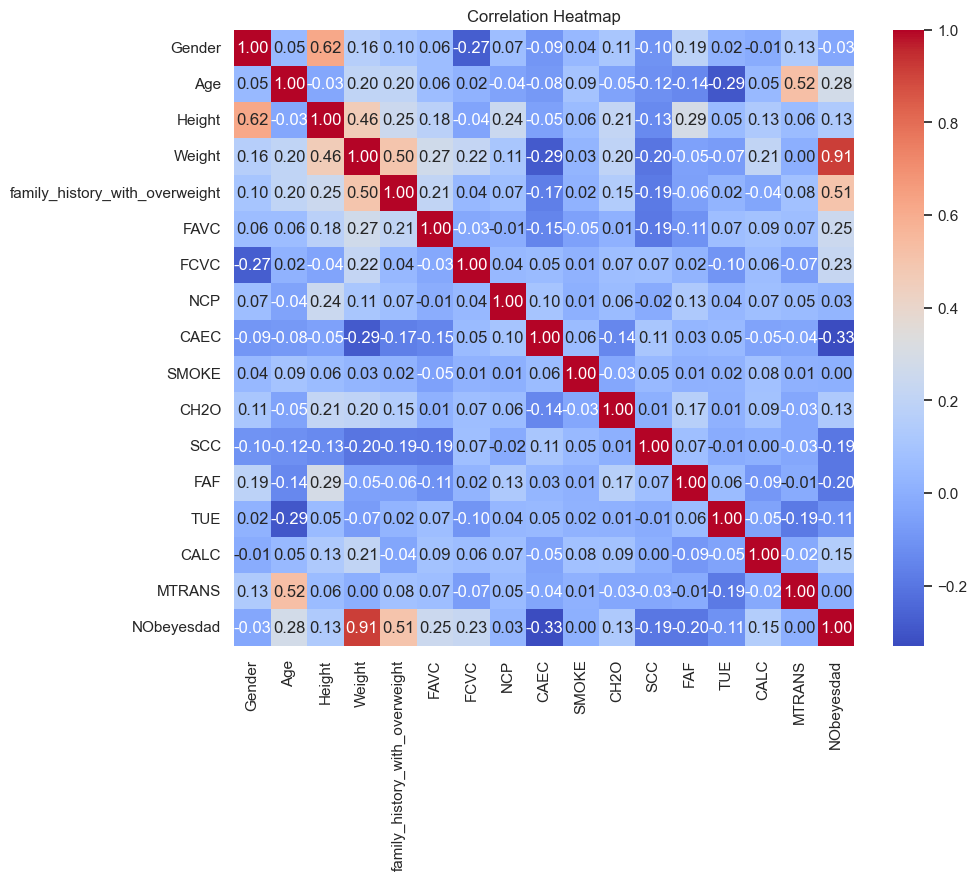

In [18]:
#Vẽ heatmap
correlation_matrix = data.corr() 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap") #đặt tiêu đề cho đồ thị
plt.show() #hiển thị đồ thị

Khi nghiên cứu về mức độ béo phì và mối liên hệ với các biến khác, việc loại bỏ các giá trị âm từ biểu đồ nhiệt tương tương quan là một bước quan trọng để đảm bảo sự chính xác của dữ liệu. Các giá trị âm có thể gây nhiễu và làm mờ đi sự thật về mối quan hệ giữa các yếu tố và mức độ béo phì. Bằng cách loại bỏ những giá trị âm như Gender = -0.03, CAEC = -0.33, SCC = -0.19, FAF = -0.2 và TUE = -0.11, em tập trung vào việc phân tích những mối liên hệ tích cực, từ đó đưa ra những nhận định và kết luận có tính khoa học và đáng tin cậy hơn về tương quan giữa các biến và mức độ béo phì. Điều này không chỉ giúp cải thiện độ chính xác của phân tích mà còn định rõ hơn về các yếu tố ảnh hưởng đến béo phì và cách chúng tương tác với nhau trong một khung cảnh nghiên cứu khoa học.

In [19]:
# Danh sách các cột cần xóa
columns_to_drop = ["Gender", "CAEC", "SCC", "FAF", "TUE"]

# Xóa các cột không cần thiết từ DataFrame
data = data.drop(columns_to_drop, axis=1)

In [20]:
data.shape

(2113, 12)

In [21]:
data.head()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,CALC,MTRANS,NObeyesdad
0,21.0,1.62,64.0,1,0,2.0,3.0,0,2.0,0,1,1
1,21.0,1.52,56.0,1,0,3.0,3.0,1,3.0,1,1,1
2,23.0,1.80,77.0,1,0,2.0,3.0,0,2.0,2,1,1
3,27.0,1.80,87.0,0,0,3.0,3.0,0,2.0,2,0,2
4,22.0,1.78,89.8,0,0,2.0,1.0,0,2.0,1,1,3


## Làm sạch dữ liệu 

### Xử lý ngoại lai
Dựa vào bảng thống kê mô tả dữ liệu dưới đây, nhận thấy rằng cột 'Age' có giá trị tối thiểu là -1. Tuy nhiên, tuổi không thể là một số âm, do đó, có thể kết luận rằng cột 'Age' chứa các giá trị ngoại lai. Để xác định rõ hơn, chúng ta sẽ quan sát biểu đồ trực quan hóa phân phối dữ liệu dưới đây.

Phạm vi tuổi của bài toán được xác định là từ 14 đến 61.

In [22]:
#Kiểm tra các thước đo thống kê của dữ liệu
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2113.0,24.299053,6.367226,-1.00,19.946244,22.771612,26.000000,61.00
Height,2112.0,1.701733,0.093318,1.45,1.630000,1.700563,1.768514,1.98
Weight,2113.0,86.568939,26.190866,39.00,65.423942,83.000000,107.378702,173.00
family_history_with_overweight,2113.0,0.817321,0.386494,0.00,1.000000,1.000000,1.000000,1.00
FAVC,2113.0,0.884051,0.320239,0.00,1.000000,1.000000,1.000000,1.00
FCVC,2113.0,2.418646,0.533829,1.00,2.000000,2.382705,3.000000,3.00
NCP,2113.0,2.685926,0.777730,1.00,2.658837,3.000000,3.000000,4.00
SMOKE,2113.0,0.020823,0.142827,0.00,0.000000,0.000000,0.000000,1.00
CH2O,2113.0,2.008004,0.612663,1.00,1.590418,2.000000,2.476002,3.00
CALC,2113.0,0.731188,0.515533,0.00,0.000000,1.000000,1.000000,3.00


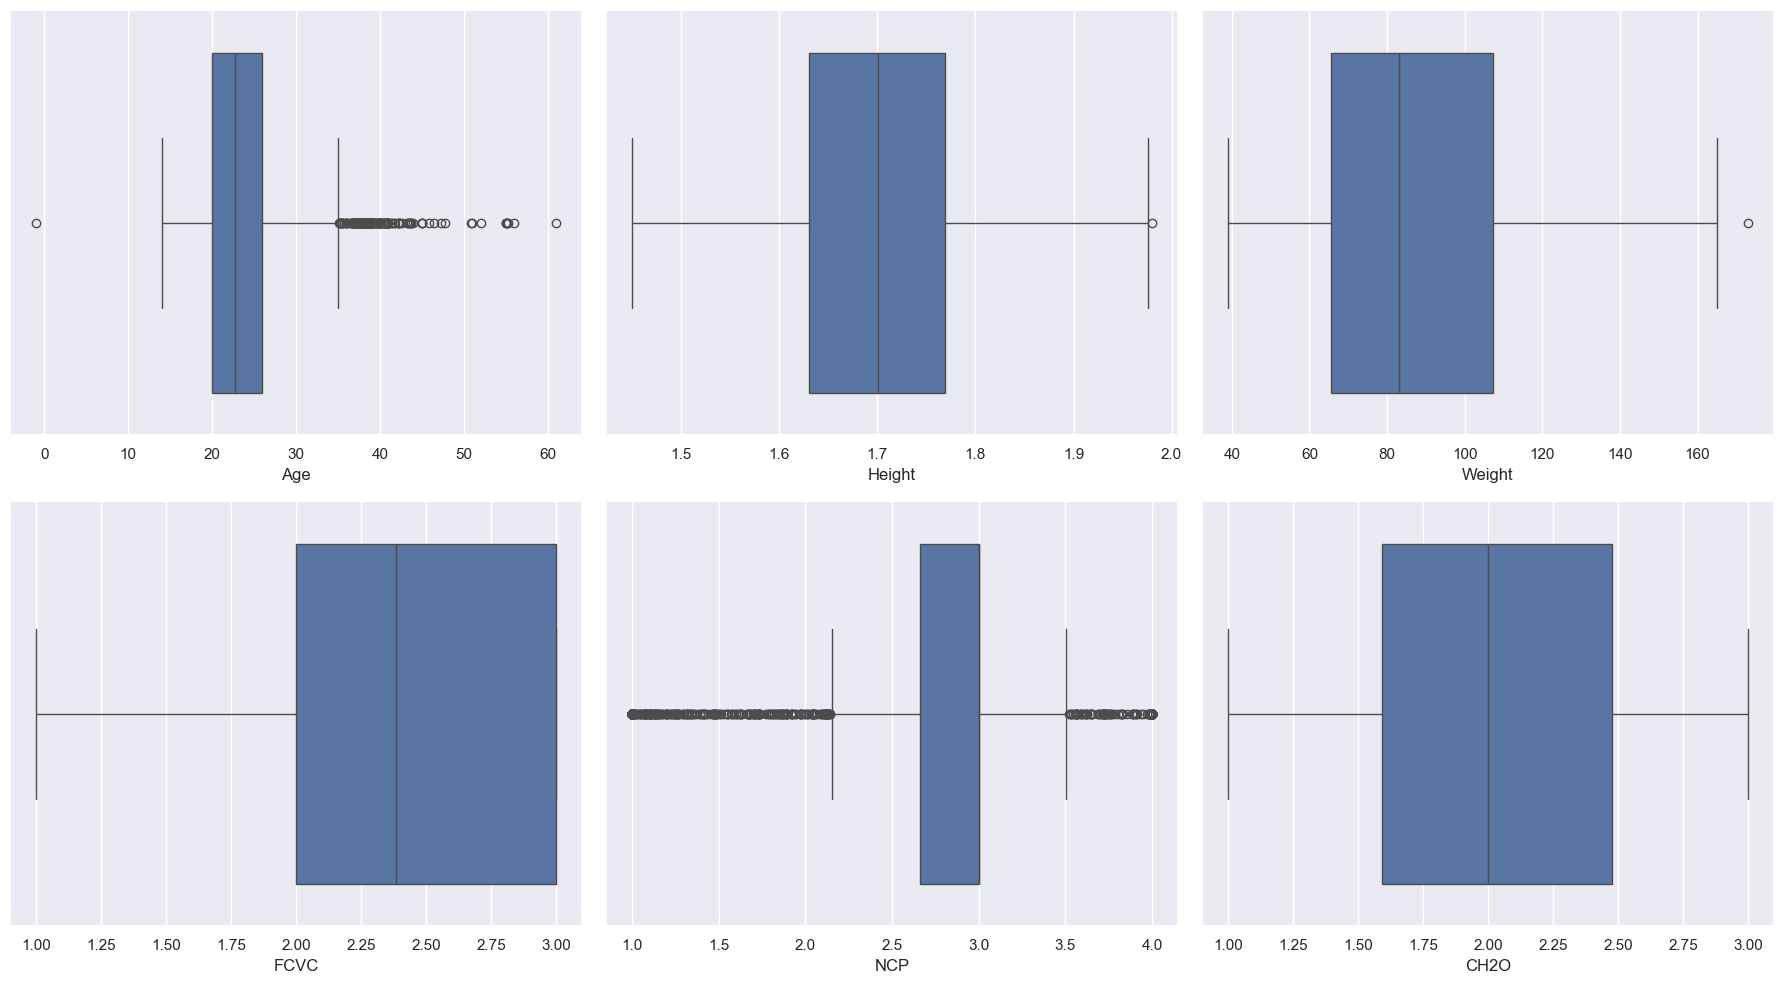

In [23]:
# các cột được chỉ định
columns_to_read = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O']

# Vẽ biểu đồ boxplot cho các cột đã chọn
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
for i, variable in enumerate(columns_to_read):
    sns.boxplot(x=variable, data=data, orient="v", ax=ax[i//3, i%3])

plt.tight_layout()
plt.show()

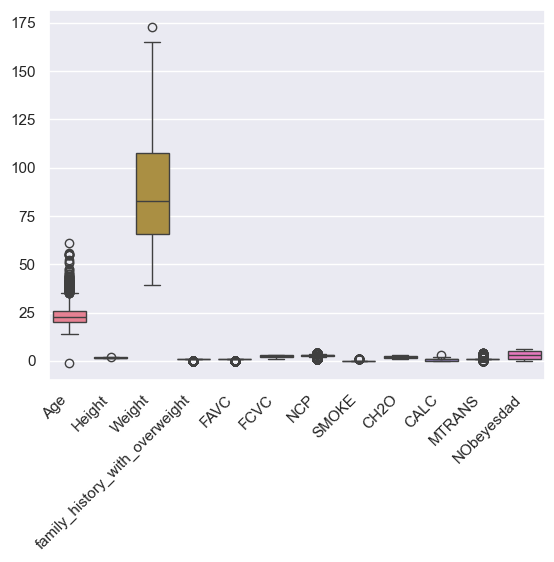

In [24]:
#Draw Boxplot to check outliers (kiểm tra ngoại lệ)
sns.boxplot(data=data)
# Điều chỉnh khoảng cách và xoay chữ
plt.xticks(rotation=45, ha='right')  # Xoay chữ 45 độ và căn chỉnh văn bản về phía phải

# Hiển thị hình vẽ
plt.show()

In [25]:
# Lọc ra các hàng có giá trị cột 'Age' nằm trong khoảng từ 14 đến 61
data = data[(data['Age'] >= 14) & (data['Age'] <= 61)]
# In ra lại thống kê mô tả của dữ liệu sau khi loại bỏ giá trị ngoại lai trong cột "Age"
print("Bảng thống kê mô tả lại dữ liệu sau khi loại bỏ giá trị ngoại lai:")
data.describe().T

Bảng thống kê mô tả lại dữ liệu sau khi loại bỏ giá trị ngoại lai:


,count,mean,std,min,25%,50%,75%,max
Age,2112.0,24.311031,6.344874,14.00,19.947666,22.774751,26.000000,61.00
Height,2111.0,1.701677,0.093305,1.45,1.630000,1.700499,1.768464,1.98
Weight,2112.0,86.568735,26.197067,39.00,65.408942,83.000000,107.404692,173.00
family_history_with_overweight,2112.0,0.817235,0.386565,0.00,1.000000,1.000000,1.000000,1.00
FAVC,2112.0,0.883996,0.320305,0.00,1.000000,1.000000,1.000000,1.00
FCVC,2112.0,2.418845,0.533878,1.00,2.000000,2.384104,3.000000,3.00
NCP,2112.0,2.685777,0.777884,1.00,2.658787,3.000000,3.000000,4.00
SMOKE,2112.0,0.020833,0.142860,0.00,0.000000,0.000000,0.000000,1.00
CH2O,2112.0,2.008008,0.612808,1.00,1.587615,2.000000,2.476711,3.00
CALC,2112.0,0.731534,0.515409,0.00,0.000000,1.000000,1.000000,3.00


Xem lại biểu đồ trực quan cột Age


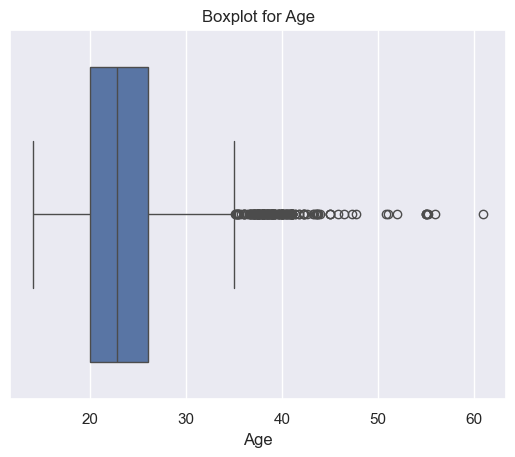

In [26]:
print("Xem lại biểu đồ trực quan cột Age")
sns.boxplot(x='Age', data=data)
plt.title('Boxplot for Age')
plt.show()

### Kiểm tra và xử lý dữ liệu thiếu

In [27]:
# Kiểm tra giá trị rỗng
missing_values = data.isnull().sum()
print("Số lượng giá trị rỗng trong mỗi cột:\n")
print(missing_values)

Số lượng giá trị rỗng trong mỗi cột:

Age                               0
Height                            1
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
SMOKE                             0
CH2O                              0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


Sau khi kiểm tra tập dữ liệu, phát hiện có một giá trị bị thiếu trong cột "Height" (chiều cao). Do đó, có thể ảnh hưởng đến tính toàn vẹn của dữ liệu. Vì vậy, để xử lý dữ liệu thiếu, quyết định chọn phương pháp loại bỏ các hàng chứa dữ liệu thiếu.

In [28]:
# Xóa các hàng chứa giá trị thiếu
data = data.dropna()

In [29]:
# In số lượng hàng và cột của dữ liệu sau khi xóa
print("Kích thước của dữ liệu sau khi xóa các hàng chứa giá trị thiếu:")
print(data.shape)

Kích thước của dữ liệu sau khi xóa các hàng chứa giá trị thiếu:
(2111, 12)


## Chia tập dữ liệu
Chia dữ liệu thành tập huấn luyện và tập kiểm tra (80/20, tức training 80% còn testing 20%)

In [30]:
# Tách biệt các tính năng và biến mục tiêu
X = data.drop('NObeyesdad', axis=1)
y = data['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
#shape: in kthc dữ liệu (số lượng mẫu, số lượng đặc trưng)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1688, 11)
(423, 11)
(1688,)
(423,)


# Xây dựng mô hình

Đối với bài toán này thì ta sẽ xem xét thuật toán: K-nearest neighbors, Decision Tree và Random Forest.

## K-nearest neighbors (KNN)

### KNN với tham số mặc định

In [32]:
# Khởi tạo mô hình KNN với số lân cận mặc định k = 5
knn_model = KNeighborsClassifier()

# Huấn luyện mô hình trên tập huấn luyện
knn_model.fit(X_train, y_train)

# Dự đoán nhãn cho tập kiểm tra
y_pred = knn_model.predict(X_test)

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
# phương thức này tạo ra một báo cáo tổng hợp về hiệu suất của mô hình trong việc phân loại.
# như precision, recall và F1-score cho từng lớp nhãn, cũng như trung bình của các chỉ số này qua tất cả các lớp.
print(f'Accuracy: {accuracy:.2f}')
print(report)

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        65
           1       0.71      0.47      0.57        57
           2       0.76      0.74      0.75        57
           3       0.83      0.78      0.80        55
           4       0.85      0.94      0.89        67
           5       0.96      0.96      0.96        53
           6       0.96      0.99      0.97        69

    accuracy                           0.85       423
   macro avg       0.84      0.84      0.83       423
weighted avg       0.84      0.85      0.84       423



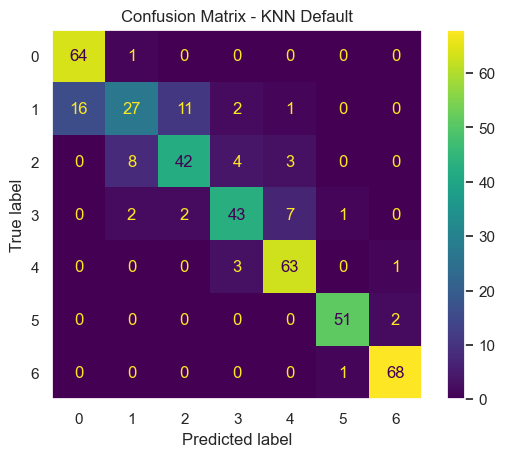

In [33]:
cm = confusion_matrix(y_test, y_pred)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot()
plt.grid(False)  # Vô hiệu hóa các đường lưới
plt.title('Confusion Matrix - KNN Default')
plt.show()

=> Kết luận từ phương pháp K-nearest neighbors (KNN) cho thấy rằng khi chia tập dữ liệu thành tập huấn luyện và tập kiểm tra theo tỉ lệ 80-20, độ chính xác (accuracy) đạt được là 85%, vượt trội hơn so với những nghiên cứu trước đó. Paul Richardson thực hiện phương pháp KNN với độ chính xác là 76%, tuy nhiên, anh ấy đã không tính đến hai biến độc lập là chiều cao (Height) và cân nặng (Weight). Trong khi đó, Pymche đạt độ chính xác là 83%, nhưng anh ấy đã chia tập dữ liệu huấn luyện và tập kiểm tra theo tỉ lệ 90-10. Điều này chỉ ra rằng việc chia tập dữ liệu cần được cân nhắc một cách kỹ lưỡng vì nó có thể có ảnh hưởng đáng kể đến hiệu suất của mô hình KNN.

Bên cạnh đó, các nghiên cứu trước đây thường không loại bỏ các thuộc tính không có mối tương quan với thuộc tính phân loại, điều này có thể dẫn đến việc mô hình KNN không hoạt động hiệu quả. Thực tế, việc loại bỏ các thuộc tính có mối tương quan âm với biến phân loại chưa được coi là một phần quan trọng trong quy trình phân tích dữ liệu trong quá khứ. Tuy nhiên, như các kết quả thể hiện, việc bao gồm các thuộc tính quan trọng và loại bỏ những thuộc tính không cần thiết có thể cải thiện đáng kể hiệu suất của mô hình, giúp làm sạch dữ liệu và tăng cường khả năng dự đoán. Điều này làm nổi bật sự cần thiết của việc đánh giá kỹ lưỡng dữ liệu đầu vào và tiến hành tiền xử lý dữ liệu thích hợp để đạt được hiệu suất tối ưu từ mô hình KNN.

### KNN với tham số weights = 'distance'

Dù em cảm thấy hài lòng với kết quả từ phương pháp bầu chọn chính thống, nhưng sự ham muốn khám phá của em không cho phép em ngừng lại ở đó. Em nhận thấy rằng việc coi mỗi điểm gần nhất có vai trò như nhau là không công bằng. Đó là lý do tại sao em quyết định áp dụng trọng số khác nhau cho các điểm gần nhất, dựa trên khoảng cách từ điểm test. Em đơn giản hóa công việc này bằng cách sử dụng Scikit-learn, nơi em chỉ cần đặt giá trị weights = 'distance'. Điều này sẽ làm cho các điểm gần hơn được đánh trọng số cao hơn, phản ánh mức độ tin tưởng vào các điểm đó. Scikit-learn trước đó cung cấp dùng giá trị mặc định của weights là 'uniform' tức là nó sử dụng kỹ thuật majority voting (trong quá trình phân loại, mỗi điểm dữ liệu mới được gán nhãn bằng cách đếm số lượng láng giềng có ở mỗi nhãn và chọn nhãn xuất hiện nhiều nhất trong số các láng giềng đó), tuy nhiên, việc sử dụng 'distance' sẽ làm cho mô hình của em trở nên linh hoạt và chính xác hơn.

In [34]:
KNN = KNeighborsClassifier(weights = 'distance')

# Huấn luyện mô hình trên tập huấn luyện
KNN.fit(X_train, y_train)

# Dự đoán nhãn cho tập kiểm tra
y_pred = KNN.predict(X_test)

# Đánh giá độ chính xác của mô hình
accuracy_weighted = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
# phương thức này tạo ra một báo cáo tổng hợp về hiệu suất của mô hình trong việc phân loại.
# như precision, recall và F1-score cho từng lớp nhãn, cũng như trung bình của các chỉ số này qua tất cả các lớp.
print(f'Accuracy: {accuracy_weighted:.2f}')
print(report)

Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        65
           1       0.76      0.46      0.57        57
           2       0.78      0.79      0.78        57
           3       0.88      0.82      0.85        55
           4       0.84      0.97      0.90        67
           5       0.98      1.00      0.99        53
           6       0.99      0.99      0.99        69

    accuracy                           0.87       423
   macro avg       0.86      0.86      0.85       423
weighted avg       0.86      0.87      0.86       423



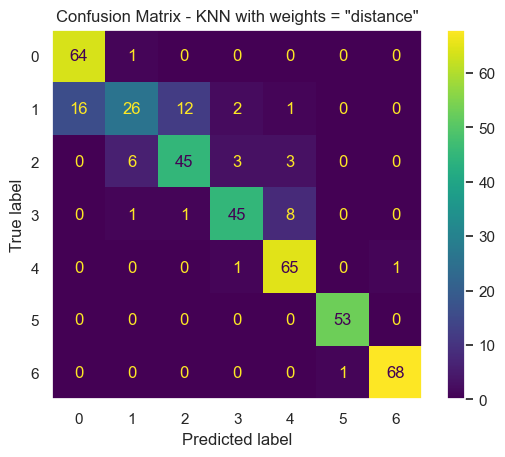

In [35]:
cm = confusion_matrix(y_test, y_pred)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot()
plt.grid(False)  # Vô hiệu hóa các đường lưới
plt.title('Confusion Matrix - KNN with weights = "distance"')
plt.show()

Bằng cách sử dụng Scikit-learn và đặt giá trị weights = 'distance', mô hình của em đã được cập nhật để sử dụng kỹ thuật này. Kết quả độ chính xác tăng lên từ 85% lên thành 87%, cho thấy rằng việc thay đổi này đã mang lại cải thiện đáng kể trong hiệu suất của mô hình. Việc này cho thấy, áp dụng trọng số khác nhau cho các điểm gần nhất dựa trên khoảng cách từ điểm test là một bước tiến quan trọng trong việc tối ưu hóa mô hình phân loại. Thay vì coi mỗi điểm láng giềng có vai trò như nhau, việc đánh trọng số cao hơn cho các điểm gần nhất phản ánh mức độ tin tưởng vào các điểm đó, điều này giúp mô hình trở nên linh hoạt và chính xác hơn.

## Decision Tree

In [36]:
# Khởi tạo mô hình cây quyết định
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Huấn luyện mô hình trên tập huấn luyện
decision_tree_model.fit(X_train, y_train)

# Dự đoán nhãn cho tập kiểm tra
y_pred = decision_tree_model.predict(X_test)

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(report)

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        65
           1       0.83      0.91      0.87        57
           2       0.90      0.82      0.86        57
           3       0.93      0.95      0.94        55
           4       0.92      0.99      0.95        67
           5       1.00      0.96      0.98        53
           6       0.99      0.97      0.98        69

    accuracy                           0.93       423
   macro avg       0.93      0.93      0.93       423
weighted avg       0.94      0.93      0.93       423



In [37]:
# Dự đoán trên tập huấn luyện
y_train_pred = decision_tree_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Dự đoán trên bộ thử nghiệm
y_test_pred = decision_tree_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# So sánh độ chính xác trên tập huấn luyện và tập kiểm tra
print("Độ chính xác trên tập huấn luyện:", train_accuracy)
print("Độ chính xác trên tập kiểm tra:", test_accuracy)

Độ chính xác trên tập huấn luyện: 1.0
Độ chính xác trên tập kiểm tra: 0.933806146572104


Mặc dù mô hình Decision Tree đạt độ chính xác tuyệt đối 1.0 trên tập huấn luyện, nhưng chỉ đạt 0.9338 trên tập kiểm tra (dữ liệu đang có mức chênh lệch 6.62% giữa độ chính xác trên tập huấn luyện và tập kiểm tra). Điều này càng củng cố thêm việc mô hình có thể đang gặp phải hiện tượng overfitting và cần được kiểm tra cũng như điều chỉnh để cải thiện khả năng tổng quát hóa trên các tập dữ liệu mới. Để giải quyết vấn đề này, cần thực hiện các biện pháp kiểm tra bổ sung và áp dụng các kỹ thuật giảm thiểu overfitting như pre-pruning hoặc post-pruning để điều chỉnh mô hình. Các biện pháp này sẽ giúp đảm bảo mô hình tổng quát hóa tốt hơn và duy trì được hiệu suất cao trên các tập dữ liệu kiểm tra. Ở đây em sử dụng kỹ thuật post-pruning.

In [48]:
# Xác định các siêu tham số và giá trị của chúng để kiểm tra
param_grid = {
    'ccp_alpha': [0.0012, 0.0014, 0.002, 0.003, 0.004, 0.0001, 0.0002],
}

# Khởi tạo phân loại cây quyết định
decisiontree_model1 = DecisionTreeClassifier(random_state=42)

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(decisiontree_model1, param_grid)

# Thực hiện GridSearchCV để tìm thông số tốt nhất
grid_search.fit(X_train, y_train)

# In các thông số tốt nhất được tìm thấy bởi GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Sử dụng công cụ ước tính tốt nhất được GridSearchCV tìm thấy để dự đoán
best_decisiontree_model = grid_search.best_estimator_

# Dự đoán trên tập thử nghiệm bằng mô hình tốt nhất
y_pred = best_decisiontree_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(report)

# Dự đoán trên tập huấn luyện bằng mô hình tốt nhất
y_train_pred = best_decisiontree_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Dự đoán trên tập thử nghiệm bằng mô hình tốt nhất
y_test_pred = best_decisiontree_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

#So sánh độ chính xác trên tập huấn luyện và tập kiểm tra bằng mô hình tốt nhất
print("Độ chính xác trên tập huấn luyện:", train_accuracy)
print("Độ chính xác trên tập kiểm tra:", test_accuracy)


Best Parameters: {'ccp_alpha': 0.0012}
Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        65
           1       0.88      0.88      0.88        57
           2       0.89      0.88      0.88        57
           3       0.95      0.95      0.95        55
           4       0.96      0.99      0.97        67
           5       1.00      0.96      0.98        53
           6       0.99      1.00      0.99        69

    accuracy                           0.95       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.95      0.95      0.95       423

Độ chính xác trên tập huấn luyện: 0.9822274881516587
Độ chính xác trên tập kiểm tra: 0.9456264775413712


=> Kết luận từ phương pháp Decision Tree khi áp dụng cắt tỉa sau, dựa trên các số liệu thu được, phương pháp cây quyết định đã cho thấy hiệu suất khá ấn tượng trong việc phân loại dữ liệu. Với độ chính xác trên tập huấn luyện đạt khoảng 98%, mô hình đã hiệu quả học được từ dữ liệu huấn luyện. Điều này ngụ ý rằng mô hình có khả năng tổng quát hóa tốt. Độ chính xác trên tập kiểm tra cũng khá cao, đạt khoảng 95% (chênh lệch khoảng 3% so với tập huấn luyện), mức chênh lệch này không quá lớn cho thấy mô hình không bị quá khớp và có khả năng áp dụng tốt cho dữ liệu mới.

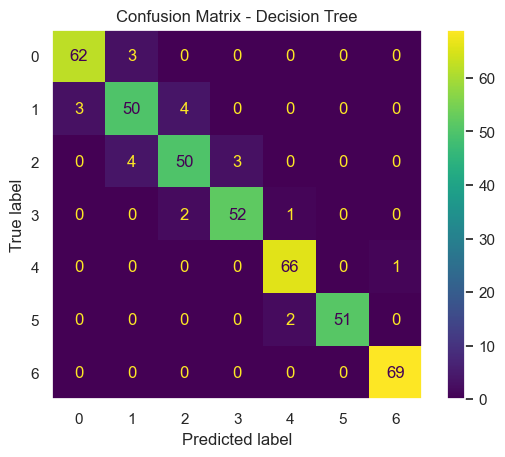

In [49]:
cm = confusion_matrix(y_test, y_pred)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_decisiontree_model.classes_)
disp.plot()
plt.grid(False)  # Vô hiệu hóa các đường lưới
plt.title('Confusion Matrix - Decision Tree')
plt.show()

In [51]:
tree_rules = export_text(best_decisiontree_model, feature_names=list(X_train.columns))
print("Decision Tree Rules:")
print(tree_rules)


Decision Tree Rules:
|--- Weight <= 99.54
|   |--- Weight <= 61.32
|   |   |--- Height <= 1.66
|   |   |   |--- Weight <= 46.83
|   |   |   |   |--- Height <= 1.51
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Height >  1.51
|   |   |   |   |   |--- class: 0
|   |   |   |--- Weight >  46.83
|   |   |   |   |--- Height <= 1.52
|   |   |   |   |   |--- Weight <= 51.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Weight >  51.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- Height >  1.52
|   |   |   |   |   |--- NCP <= 3.28
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- NCP >  3.28
|   |   |   |   |   |   |--- NCP <= 3.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- NCP >  3.95
|   |   |   |   |   |   |   |--- class: 1
|   |   |--- Height >  1.66
|   |   |   |--- Weight <= 59.97
|   |   |   |   |--- Weight <= 55.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Weight >  55.00
|   |   |   |   |   |-

Cây quyết định sau khi cắt tỉa post-pruning đã loại bỏ 2 thuộc tính (SMOKE và MTRANS) không có mối tương quan đáng kể với mức độ béo phì (NObeyesdad). Điều này cho thấy rằng mô hình đã tự động phát hiện và loại bỏ các yếu tố không cần thiết hoặc không ảnh hưởng đến kết quả dự đoán. Quá trình này có thể được coi là một biện pháp tự động hóa quan trọng trong việc xây dựng mô hình, giúp giảm bớt sự phức tạp của cây quyết định và tăng tính tổng quát của mô hình. Bằng cách loại bỏ những thuộc tính không cần thiết, mô hình trở nên dễ diễn giải hơn và ít bị ảnh hưởng bởi nhiễu trong dữ liệu.

In [52]:
# Lấy số lượng mẫu tại mỗi nút
node_samples = best_decisiontree_model.tree_.n_node_samples

# Tổng số mẫu được sử dụng để xây dựng cây quyết định là tổng số mẫu tại nút gốc
total_samples = node_samples[0]

print("Tổng số mẫu được sử dụng để xây dựng cây quyết định:", total_samples)


Tổng số mẫu được sử dụng để xây dựng cây quyết định: 1688


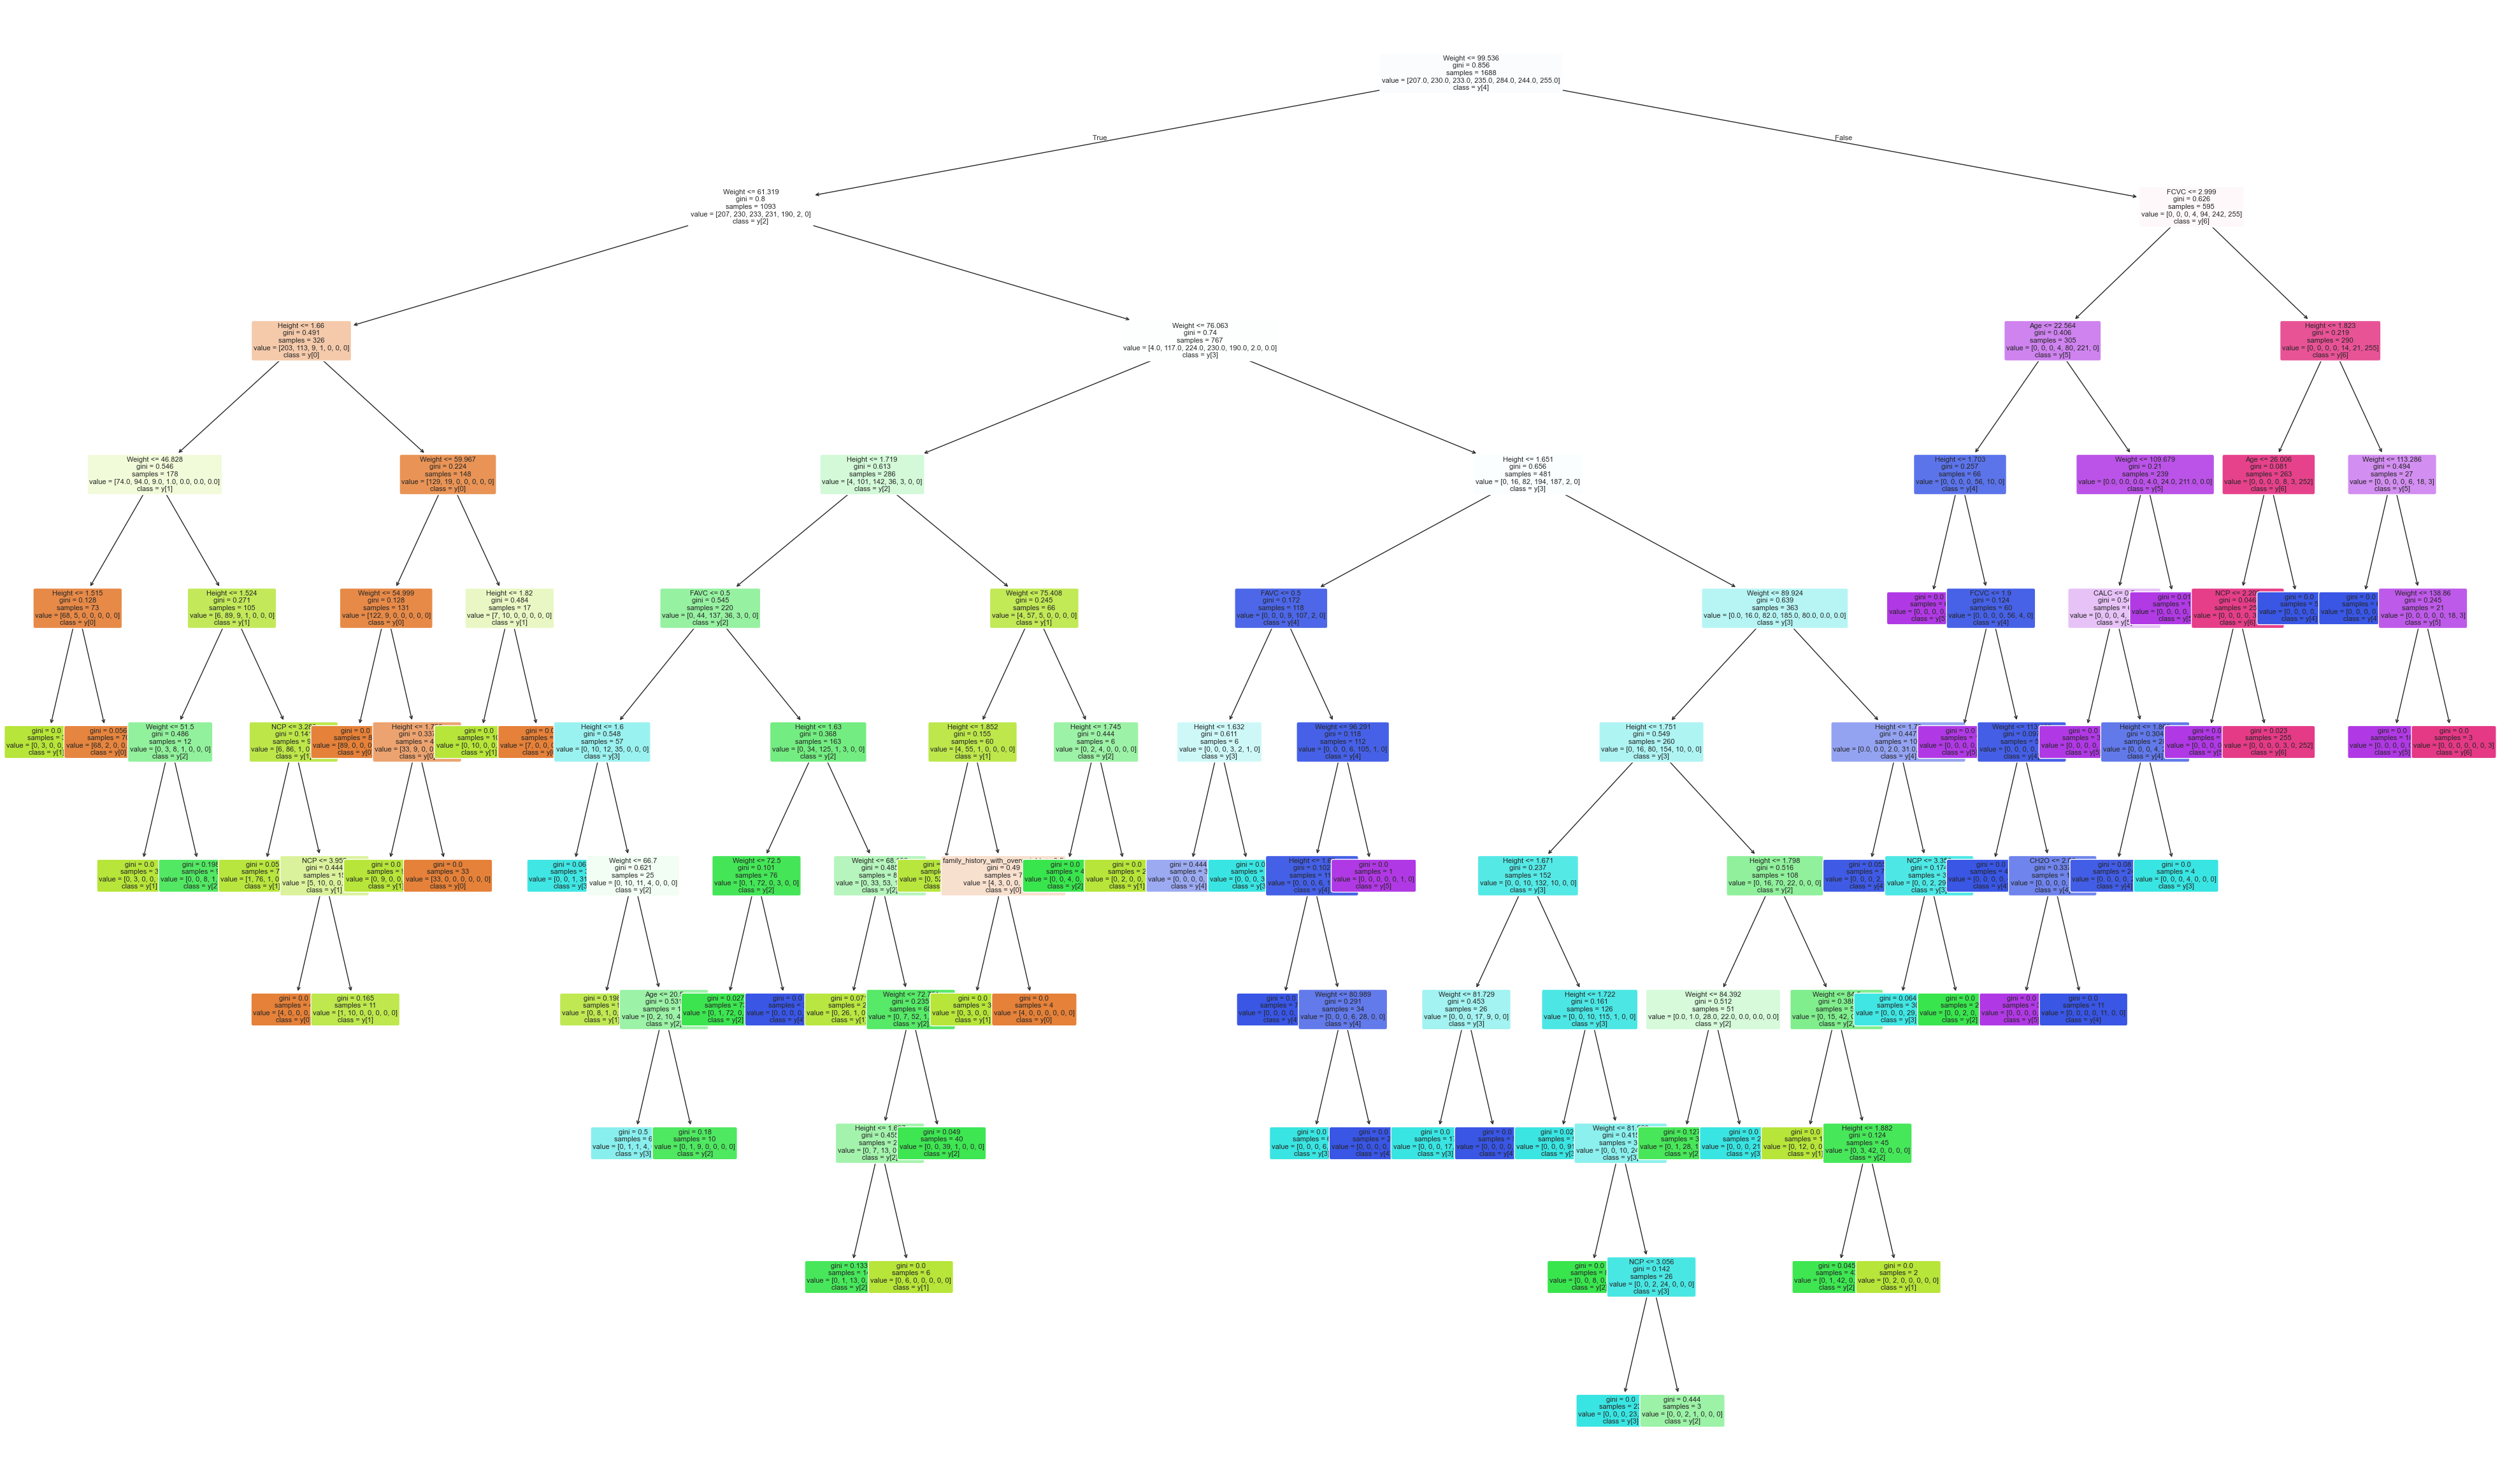

In [53]:
# Tạo hình vẽ và thiết lập kích thước lớn hơn
plt.figure(figsize=(50, 30))

# Vẽ cây quyết định với font size lớn hơn
plot_tree(best_decisiontree_model, filled=True, rounded=True, class_names=True, feature_names=X.columns, fontsize=8)

# Hiển thị cây quyết định
plt.show()


In [54]:
# Số lượng lá của cây
num_leaves = best_decisiontree_model.tree_.n_leaves

# Số lượng nút của cây
num_nodes = best_decisiontree_model.tree_.node_count

print("Số lá của cây quyết định:", num_leaves)
print("Số nút của cây quyết định:", num_nodes)

Số lá của cây quyết định: 62
Số nút của cây quyết định: 123


## Random Forest

In [44]:
# Khởi tạo mô hình RandomForestClassifier ban đầu
rf_model = RandomForestClassifier(random_state=42)

# Định nghĩa các siêu tham số mà bạn muốn tinh chỉnh
param_grid = {
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt','log2'],
    'ccp_alpha': [0.0, 0.01, 0.02, 0.001, 0.002, 0.003, 0.004]
}

# Khởi tạo một GridSearchCV với mô hình RandomForestClassifier và các siêu tham số đã chỉ định
grid_search = GridSearchCV(rf_model, param_grid, scoring='accuracy')

# Huấn luyện GridSearchCV trên tập huấn luyện
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất được tìm thấy
print("Best parameters found: ", grid_search.best_params_)

best_rf_model = grid_search.best_estimator_

# Dự đoán nhãn cho tập kiểm tra bằng mô hình đã được tinh chỉnh
y_pred = best_rf_model.predict(X_test)

# Đánh giá độ chính xác của mô hình sau khi tinh chỉnh
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy after tuning: {accuracy:.2f}')
print(report)


Best parameters found:  {'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt'}
Accuracy after tuning: 0.96
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        65
           1       0.81      1.00      0.90        57
           2       1.00      0.88      0.93        57
           3       0.96      0.93      0.94        55
           4       0.97      0.97      0.97        67
           5       1.00      0.98      0.99        53
           6       0.99      1.00      0.99        69

    accuracy                           0.96       423
   macro avg       0.96      0.96      0.96       423
weighted avg       0.96      0.96      0.96       423



Dựa trên kết quả được trình bày, có vẻ như việc sử dụng các tham số mặc định của thuật toán Random Forest trong thư viện scikit-learn đã dẫn đến kết quả tối ưu nhất cho bài toán được nghiên cứu. Điều này làm nổi bật một điểm đáng chú ý: trong một số trường hợp, việc giữ mô hình đơn giản có thể dẫn đến hiệu suất cao nhất trong học máy. Các tham số mặc định thường phản ánh một sự cân nhắc tỉ mỉ giữa độ phức tạp của mô hình và khả năng tổng quát hoá của nó. Trong trường hợp này, chúng đã đủ để tránh overfitting mà vẫn giữ được khả năng học mẫu trên dữ liệu mới. Điều này thường xuyên được đề cập trong nghiên cứu về học máy: không phải lúc nào cũng cần thiết phải tinh chỉnh mọi thứ đến tận cùng, mà thường là việc tìm ra sự cân bằng phù hợp giữa sự đơn giản và hiệu suất. Việc sử dụng các tham số mặc định cũng giảm bớt phần nào công đoạn tinh chỉnh và thử nghiệm tham số, từ đó tiết kiệm thời gian và công sức của nhà nghiên cứu. Điều này mang lại một ưu điểm quan trọng trong việc phát triển và triển khai các mô hình học máy trong thực tế.

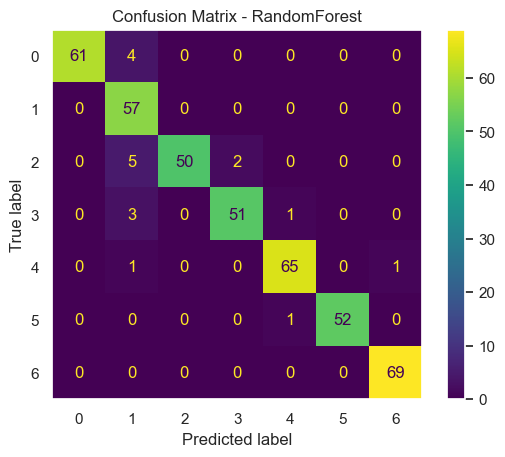

In [45]:
cm = confusion_matrix(y_test, y_pred)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_model.classes_)
disp.plot()
plt.grid(False)  # Vô hiệu hóa các đường lưới
plt.title('Confusion Matrix - RandomForest')
plt.show()

## KẾT LUẬN:

+ Kết quả của thuật toán KNN, Decision Tree và Random Forest cho thấy cả ba đều đạt được mức độ chính xác khá cao trên tập dữ liệu kiểm tra. Random Forest có vẻ hiệu quả hơn với độ chính xác lên đến 96% so với 87% của KNN và 95% của Decision Tree.

+ Khi so sánh các chỉ số precision, recall và f1-score, ta thấy rằng Random Forest có nhiều kết quả tốt hơn so với KNN và cao hơn một chút so với Decision Tree. Điều này có thể biểu thị cho việc Random Forest đã học được cấu trúc tốt hơn trong tập dữ liệu huấn luyện hoặc có khả năng tổng quát hóa tốt hơn trên tập dữ liệu kiểm tra.

+ Tóm lại, dựa trên kết quả thử nghiệm này, có vẻ như Random Forest là lựa chọn tốt hơn cho bài toán phân loại mức độ béo phì so với KNN và Decision Tree.

# Triển khai

Để triển khai ứng dụng mô hình tốt nhất vào ứng dụng Website em sử dụng pikcle để lưu trữ mô hình. Điều này cho phép em sau này có thể tải lại mô hình từ tệp tin này bằng cách sử dụng pickle.load, mà không cần phải huấn luyện lại mô hình từ đầu. Điều này tiết kiệm thời gian và công sức, đồng thời giảm thiểu khả năng mất mát thông tin trong quá trình tái huấn luyện. Ứng dụng Website được em xây dựng ở file 'ObesityDataSet_raw_and_data_sinthetic.py'.

In [46]:
import pickle

In [47]:
pickle.dump(best_rf_model, open('RandomForest_Model.pkl','wb'))